# Pretrained CNN - VGG16
In this notebook we use *VGG16* as feature-extractor in order to solve our malaria classification task

To use *VGG16* as feature-extractor, we use the pre-trained model just substituting its top layer in such a way to use the model for detecting malaria infection in blood cells and we just train the new part of network.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/PieTempesti98/CNNMalariaDetector/blob/master/VGG16_feature_extraction.ipynb)



In [ ]:
# imports
import os
import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow import keras as ks
from tensorflow.keras import layers, models, optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.applications import VGG16
from sklearn import metrics
from google.colab import drive
import matplotlib.pyplot as plt
import numpy as np
from IPython.core.display import Image

In [ ]:
# global parameters
AUTO = tf.data.experimental.AUTOTUNE
BATCH_SIZE = 256
SEED = 20

In [ ]:
# set always the same seed i order to obtain reproducible results
os.environ['PYTHONHASHSEED'] = '0'
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
# path settings and mount of google drive folders

PROJECT_DIR_PATH = "/content/drive/MyDrive/Colab Notebooks/cidl_project"
MODELS_DIR_PATH = "/models/"
IMAGES_DIR_PATH = PROJECT_DIR_PATH + "/images/"

# mount google drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


## Dataset import and pre-processing
In this subsection we import the dataset and we peform some pre-processing operations over it.

In [ ]:
# load malaria dataset from Tensorflow and split it in train, test and validation
(train_ds, val_ds, test_ds), info = tfds.load(
    'malaria',
    as_supervised=True,
    split=['train[:80%]','train[80%:85%]', 'train[85%:]'],
    with_info=True
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/27558 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/malaria/1.0.0.incomplete0PUFBN/malaria-train.tfrecord*...:   0%|          …

Dataset malaria downloaded and prepared to /root/tensorflow_datasets/malaria/1.0.0. Subsequent calls will reuse this data.


### Image rescaling
All the images are rescaled to a 224x224 size.

In [ ]:
# image rescaling
@tf.function
def scale_resize_image(image, label):
    image = tf.image.convert_image_dtype(image, tf.float32) # equivalent to dividing image pixels by 255
    image = tf.image.resize(image, (224, 224)) # Resizing the image
    return (image, label)

In [ ]:
# mapping of all the sets
train_ds = (
    train_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

test_ds = (
    test_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

val_ds = (
    val_ds
    .map(scale_resize_image, num_parallel_calls=AUTO)
    .batch(BATCH_SIZE)
    .prefetch(AUTO)
)

## Model utils
The following function is used to evaluate the models.

### Model compile and train utils

In [ ]:
def compile_model (model, learning_rate):
  '''
  compile_model is used to compile and train the current model
  :param model: model to compile
  :param learning_rate: learning rate parameter for the optimizer
  '''
  # compile the model
  model.compile(
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()]
          )
  model.summary()
  return model

In [ ]:
def run_model (model):
  # define call-back for check-point
  check_point = ks.callbacks.ModelCheckpoint(
                          filepath = PROJECT_DIR_PATH + MODELS_DIR_PATH + model.name + '.h5',
                          monitor="val_loss",
                          verbose=1,
                          save_best_only=True)

  # call-back function for early termination
  stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)
  # train the model
  history = model.fit(train_ds, epochs=100, shuffle=True, validation_data=val_ds, callbacks = [stop_early, check_point])
  return history

### Evaluation utils

In [ ]:
# Model evaluation function
def evaluate_model (model):
  '''
  evaluate_model is used to plot some statistics about the performance on the test set
  :param model: model to consider
  '''
  model = ks.models.load_model(PROJECT_DIR_PATH + MODELS_DIR_PATH + model.name + '.h5')
  y_score = model.predict(test_ds)
  y_pred = np.rint(y_score) # to have 0 or 1
  y_true = tf.concat([labels_batch for data_batch, labels_batch in test_ds], axis = 0)
  print("Classification report: ")
  print(metrics.classification_report(y_true,y_pred,digits = 4))
  metrics.ConfusionMatrixDisplay.from_predictions(y_true, y_pred)

  # ROC curve
  fpr,tpr,th = metrics.roc_curve(y_true,y_score)
  roc_auc = metrics.roc_auc_score(y_true,y_score)

  plt.figure()
  plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc)
  plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.0])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title('ROC curve')
  plt.legend(loc="lower right")
  plt.show()

In [ ]:
# Model train-test-evaluation  functions
def show_train_val_performance(history):
  '''
  show_training_and_validation_performance is used to plot the performances during the training phase
  :param history: object in which are recorded all the events
  '''
  acc = history.history['binary_accuracy']
  val_acc = history.history['val_binary_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  plt.plot(epochs, acc, 'bo', label='Training accuracy')
  plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
  plt.title('Training and validation accuracy')
  plt.legend()

  plt.figure()

  plt.plot(epochs, loss, 'bo', label='Training loss')
  plt.plot(epochs, val_loss, 'b', label='Validation loss')
  plt.title('Training and validation loss')
  plt.legend()

  plt.show()

## VGG16: feature extraction

### Preparing the network for feature extraction
Now we load *VGG16*'s convolutional base and we will properly freeze the layers in order to use the pre-trained neural network for feature extraction. In particular we freeze the pre-trained convolutional basis so that the parameters of the frozen layers won't change during the training.

On top of *VGG16*'s convolutional base we will build different models and we will compare them.



In [ ]:
# instantiate VGG16 model
conv_base = ks.applications.vgg16.VGG16(
    weights="imagenet",
    include_top=False, # we don't need the last 3 layers (classification ones)
    input_shape=(224,224,3)
)

conv_base.summary()

58889256/58889256 [==============================] - 3s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                              

In [ ]:
# freeze the convolutional basis since we perform feature extraction
conv_base.trainable = False

### Simple model
As first experiment we build a very simple network by directly connecting to the pre-trained convolutional basis of *VGG16* a fully connected layer whose 256 neurons feed the output layer containing a single neuron with Sigmoid activation function (we are dealing with a binary classification task).

In [ ]:
# concatenate a binary classifier to the frozen convolutional basis
inputs = ks.Input(shape=(224,224,3))
x = ks.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation = "relu")(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # binary classification
simple_model = ks.Model(inputs = inputs, outputs = outputs, name = 'VGG16_feature_extraction_simple_model')

In [ ]:
# compile the model
simple_model = compile_model(simple_model, 0.001)

Model: "VGG16_feature_extraction_simple_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                             

In [ ]:
# train the model
history = run_model(simple_model)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 1.0231 - binary_accuracy: 0.4975
Epoch 1: val_loss improved from inf to 0.68641, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/VGG16_feature_extraction_simple_model.h5
87/87 [==============================] - 140s 1s/step - loss: 1.0231 - binary_accuracy: 0.4975 - val_loss: 0.6864 - val_binary_accuracy: 0.6067
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.7014 - binary_accuracy: 0.5272
Epoch 2: val_loss improved from 0.68641 to 0.67768, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/VGG16_feature_extraction_simple_model.h5
87/87 [==============================] - 98s 1s/step - loss: 0.7014 - binary_accuracy: 0.5272 - val_loss: 0.6777 - val_binary_accuracy: 0.6132
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.6941 - binary_accuracy: 0.5430
Epoch 3: val_loss improved from 0.67768 to 0.67732, saving model to /conten

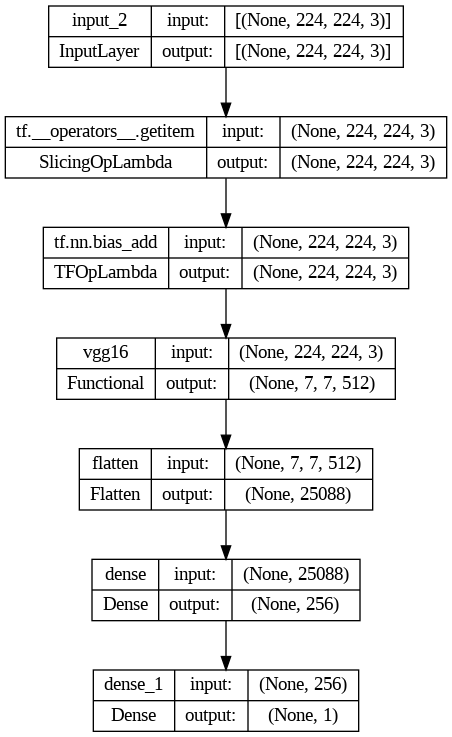

In [ ]:
# display model structure
plot_model(simple_model, 'VGG16_feature_extraction_simple_model.png', show_shapes=True, show_layer_names=True)
display(Image(filename="VGG16_feature_extraction_simple_model.png"))

17/17 [==============================] - 20s 1s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.6633    0.5355    0.5926      2086
           1     0.6045    0.7231    0.6585      2048

    accuracy                         0.6284      4134
   macro avg     0.6339    0.6293    0.6255      4134
weighted avg     0.6342    0.6284    0.6252      4134



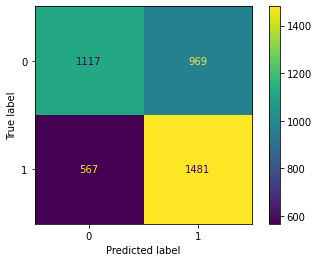

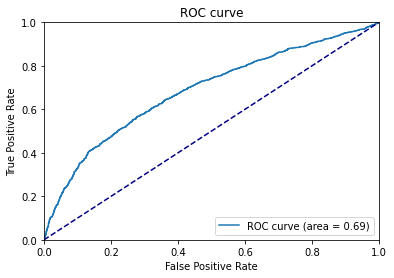

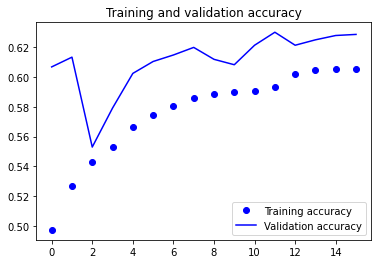

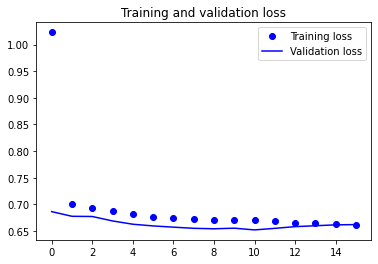

In [ ]:
# evaluate model
evaluate_model(simple_model)
show_train_val_performance(history)

### Droput model
As second experiment we add a **dropout layer** to the simple model in such a way to prevent overfitting.

In [ ]:
# concatenate a binary classifier to the frozen convolutional basis
inputs = ks.Input(shape=(224,224,3))
x = ks.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.Flatten()(x)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dropout(0.2)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # binary classification
dropout_model = ks.Model(inputs = inputs, outputs=outputs, name = 'VGG16_feature_extraction_dropout')

In [ ]:
# compile the model
dropout_model = compile_model(dropout_model, 0.001)

Model: "VGG16_feature_extraction_dropout"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem (S  (None, 224, 224, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 224, 224, 3)      0         
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 256)               6422784   
                                  

In [ ]:
# train the model
history = run_model(dropout_model)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 1.1876 - binary_accuracy: 0.5076
Epoch 1: val_loss improved from inf to 0.69228, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/VGG16_feature_extraction_dropout.h5
87/87 [==============================] - 138s 1s/step - loss: 1.1876 - binary_accuracy: 0.5076 - val_loss: 0.6923 - val_binary_accuracy: 0.5036
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.6931 - binary_accuracy: 0.5119
Epoch 2: val_loss did not improve from 0.69228
87/87 [==============================] - 97s 1s/step - loss: 0.6931 - binary_accuracy: 0.5119 - val_loss: 0.6924 - val_binary_accuracy: 0.5036
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.6927 - binary_accuracy: 0.5121
Epoch 3: val_loss improved from 0.69228 to 0.69208, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/VGG16_feature_extraction_dropout.h5
87/87 [==============================]

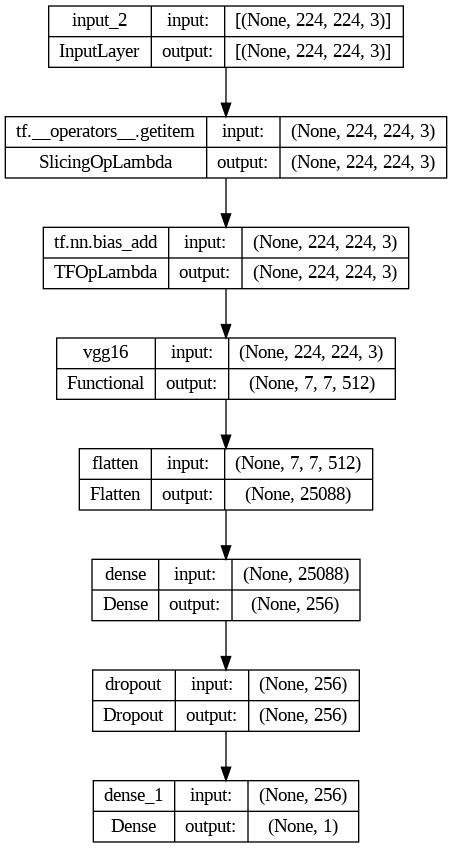

In [ ]:
# display model structure
plot_model(dropout_model, 'VGG16_feature_extraction_dropout.png', show_shapes=True, show_layer_names=True)
display(Image(filename="VGG16_feature_extraction_dropout.png"))

17/17 [==============================] - 20s 1s/step
Classification report: 
              precision    recall  f1-score   support

           0     0.5050    1.0000    0.6711      2086
           1     1.0000    0.0015    0.0029      2048

    accuracy                         0.5053      4134
   macro avg     0.7525    0.5007    0.3370      4134
weighted avg     0.7502    0.5053    0.3401      4134



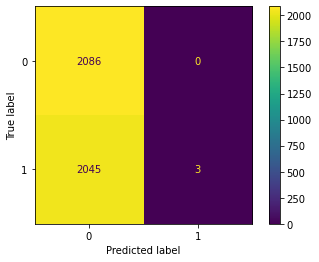

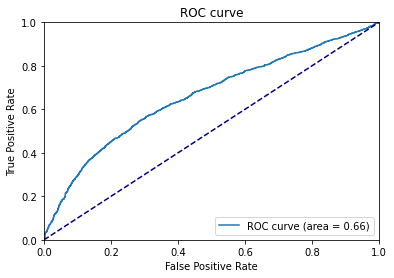

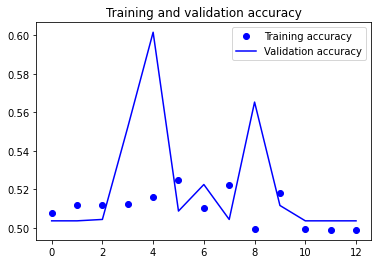

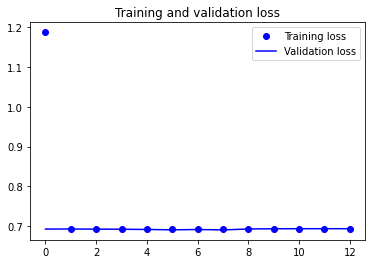

In [ ]:
# evaluate model
evaluate_model(dropout_model)
show_train_val_performance(history)

### Global Average Pooling model

In [ ]:
# concatenate a binary classifier to the frozen convolutional basis
inputs = ks.Input(shape=(224,224,3))
x = ks.applications.vgg16.preprocess_input(inputs)
x = conv_base(x)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dense(256, activation = "relu")(x)
x = layers.Dropout(0.3)(x)
outputs = layers.Dense(1, activation="sigmoid")(x) # binary classification
another_model = ks.Model(inputs = inputs, outputs = outputs, name = 'VGG16_feature_extraction_global_avg_model')

In [ ]:
# compile the model
another_model = compile_model(another_model, 0.001)

Model: "VGG16_feature_extraction_global_avg_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.__operators__.getitem_1   (None, 224, 224, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 global_average_pooling2d (G  (None, 512)              0         
 lobalAveragePooling2D)                                          
                         

In [21]:
# train the model
history = run_model(another_model)

Epoch 1/100
87/87 [==============================] - ETA: 0s - loss: 0.8035 - binary_accuracy: 0.5025
Epoch 1: val_loss improved from inf to 0.69284, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/VGG16_feature_extraction_global_avg_model.h5
87/87 [==============================] - 99s 1s/step - loss: 0.8035 - binary_accuracy: 0.5025 - val_loss: 0.6928 - val_binary_accuracy: 0.5036
Epoch 2/100
87/87 [==============================] - ETA: 0s - loss: 0.7205 - binary_accuracy: 0.5040
Epoch 2: val_loss did not improve from 0.69284
87/87 [==============================] - 97s 1s/step - loss: 0.7205 - binary_accuracy: 0.5040 - val_loss: 0.6931 - val_binary_accuracy: 0.5036
Epoch 3/100
87/87 [==============================] - ETA: 0s - loss: 0.7063 - binary_accuracy: 0.5045
Epoch 3: val_loss improved from 0.69284 to 0.69215, saving model to /content/drive/MyDrive/Colab Notebooks/cidl_project/models/VGG16_feature_extraction_global_avg_model.h5
87/87 [==============

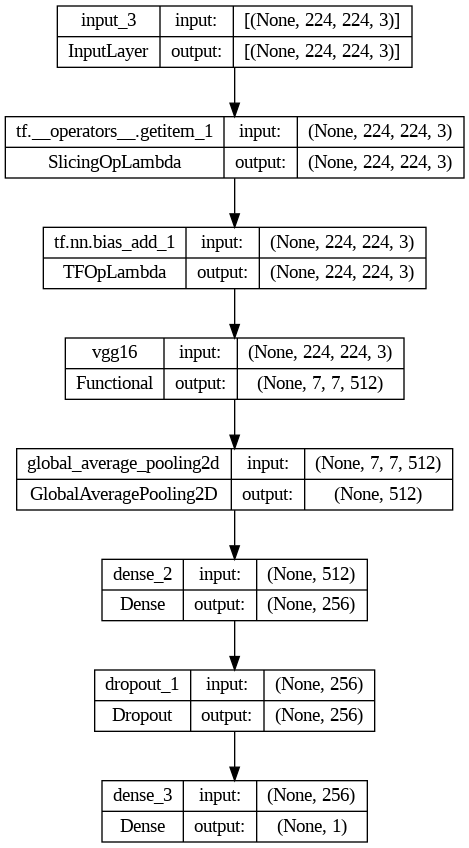

In [22]:
# display model structure
plot_model(another_model, 'VGG16_feature_extraction_global_avg_model.png', show_shapes=True, show_layer_names=True)
display(Image(filename="VGG16_feature_extraction_global_avg_model.png"))

17/17 [==============================] - 16s 984ms/step
Classification report: 
              precision    recall  f1-score   support

           0     0.5056    0.9952    0.6705      2086
           1     0.6429    0.0088    0.0173      2048

    accuracy                         0.5065      4134
   macro avg     0.5742    0.5020    0.3439      4134
weighted avg     0.5736    0.5065    0.3469      4134



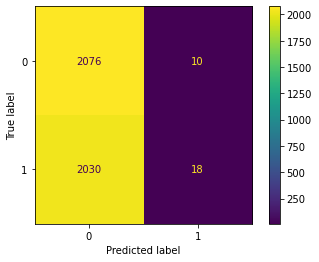

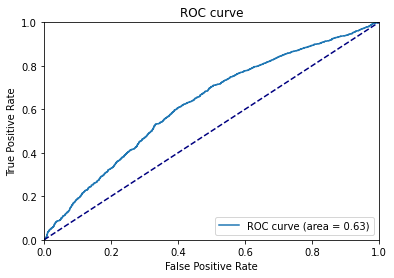

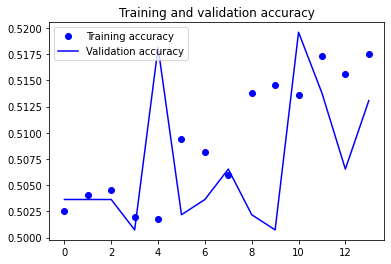

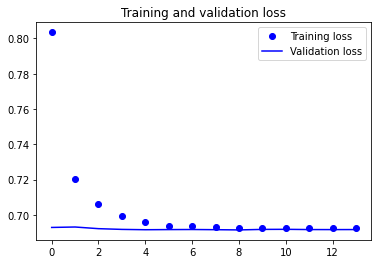

In [23]:
# evaluate model
evaluate_model(another_model)
show_train_val_performance(history)